About to rerun this but will alter the way obsids are stored, going to comment out old one and write new one in above it.  Revert if it doesn't work.

In [5]:
#Import all the tools we'll need
import pandas as pd
import geopandas as gp
import shapely as sp
from shapely.geometry import Point, Polygon, MultiPolygon
import numpy as np
from itertools import combinations
import intake
from shapely.geometry import MultiPoint
import matplotlib.pyplot as plt

C:\Users\Zade Alfalah\AppData\Local\conda\conda\envs\py37\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [6]:
#Michael's code, gets the polygon of an obsid
def get_outer_polygon_for_obsid(obsid, return_hull=True):
    tiles = pd.read_csv("tile_coordinates.csv")
    obsid_tiles = tiles.query("obsid == @obsid")
    cols = "BodyFixedCoordinateX BodyFixedCoordinateY".split()
    coords = obsid_tiles[cols]
    coords.columns = ["x", "y"]
    mp = MultiPoint(list(zip(coords.x, coords.y)))
    if return_hull:
        return mp.convex_hull
    else:
        return mp

The overall idea of the currently broken piece of interchecker code is to:
1) Take the 0th polygon of a list of polygons and intersection it with all other individual polygons
    1a) If the minimum area is 0, that is the intersection area of that combination of polygons
    1b) If the minimum area is <0, there was a critical error, but that hasn't happened yet
    1c) If the minimum area was >0, move to step 2
2) Take the minimum combination area, and the polygons that created it through their intersection, call that intersection polygon 'z' for example.  Then intersection 'z' with all other individual remaining polygons
    2a) If the minimum intersection of 'z' with the individual polygons is 0, then 'z' is our largest possible combination, and we set the combination's area to 0
    2b) if the minimum intersection of 'z' with all other individual remaining polygons is >0, we repeat step 2, and continue to do so until there are no more individual polygons remaining in the bucket.  At this point, if the intersectional area of that is >0, we call that the intersection area and move to the next combination.
    
    If this works as I mean it to above, then only those which have a non-zero intersection area for ALL of the polygons in the bucket will report the non-zero area, which is exactly what we want and what wasn't working in my original code.

In [7]:
#My code, goes through every possible combination of polygons and gives areas
def interchecker(polygon_array):
    """
    
    """
    #This block below gets our combinations of polygons, works as intended
    bucket2 = []
    combos = []
    iterable1 = range(len(polygon_array)) 
    p = len(polygon_array)
    for n in iterable1:
        if p > 0:
            comb = list(combinations(iterable1,p))
            for item in comb:
                x = item
                combos.append(x)
            p = p-1
        else:
            end

    #the above gives us an array of each possible combination eg
    #combos = [comb[0],comb[1],...]
    #where comb[0] could be (0,1,2,4) or something of the sort
    
    #This is the broken piece.  Below, labeled 'OLD INTERCHECKER' and commented out is how it was done before.
    for ele in combos:
    #ele looks like (polygon0, polygon1, polygon2, ...)
        d = {}
        #create a blank dictionary
        bucket = []
        #create an empty bucket
        for number in ele:
            #where number would be (for example) polygon0
            bucket.append(polygon_array[number])
        #bucket now [poly0, poly1, poly2, poly4] if using comb[0] above
        d['elements_used'] = bucket
        #give the dictionary the polygons used
        Multi = MultiPolygon(bucket)
        #create a multipolygon out of the polygons used
        d['multipolygon'] = Multi
        #create a dictionary input of the overall multipolygon
        if len(bucket)>1:  
            #if the bucket has one or more element in it
            bucket4 = []
            #will fill bucket 4 with the intersection polygons themselves
            bucket5 = []
            #will fill bucket 5 with the intersection polygon areas
            for num in bucket[1:]:
                #first step, take the 0th polygon and intersection it with all other polygons in the bucket
                bucket4.append(bucket[0].intersection(num))
                bucket5.append((bucket[0].intersection(num)).area)
            if min(bucket5) == 0:
                #if the minimum area of one of the intersections is zero, set the entire combinations area to zero
                d["combo_area"] = 0
                print(0)
            if min(bucket5) < 0: 
                #if the area of the intersection is less than zero I want to know, but haven't had this happen yet
                print("Something went wrong, negative area")
            if min(bucket5) > 0:
                #if the intersection area is greater than zero then we now have work to do
                x = bucket5.index(min(bucket5))
                #I set the index of the minimum combination to 'x'
                bucket6 = [min(bucket5)]
                #set bucket6 to be the minimum area
                bucket.pop(x)
                bucket.pop(0)
                #popping x, and 0 removes the two polygons already used from bucket
            
#I want the code below to take the intersectioned polygon, and intersection it with the remaining individual polygons that
#are in bucket.  I want it to set d['combo area'] == 0 if the minimum intersection area ever goes to zero before every
#polygon in the bucket is used.  Otherwise I want it to take the minimum intersection area of the new intersection, 
#pop out the polygon that was used to create it, then intersection that new intersection with the remaining polygons
#in the bucket.  Once every polygon in bucket is used, the intersection area of that polygon should be the total intersection
#area of all of the polygons in the bucket.

                while len(bucket) > 0:
                #do this over and over until all the polygons have been intersected
                    print(bucket5.index(min(bucket5)))
                    print(bucket5.index(min(bucket5)))
                    #the two print statements above are for testing output
                    s_p = bucket4[bucket5.index(min(bucket5))] #Store (intersection) Polygon 
                    s_a = bucket5[bucket5.index(min(bucket5))] #Store (intersection polygon) Area
                    bucket4 = []
                    bucket5 = []
                    #empty the bucket4 and bucket5 after each intersection is saved
                    for thing in bucket:
                        #go through the remaining polygons in the bucket and do the intersections with our
                        #saved non-zero intersection
                        bucket4.append(s_p.intersection(thing))
                        bucket5.append((s_p.intersection(thing)).area)
                    bucket6 = min(bucket5)
                    #set bucket6 to be the minimum of the 'new' intersection every time it loops
                    x = bucket5.index(min(bucket5))
                    #set the index of the minimum to be 'x' so as to pop it out of bucket after every loop
                    bucket.pop(x)
                    
                d["combo_area"] = bucket6
                #set the combo area to the minimum total intersection area
                print(bucket6)
                #print statement for testing

                #this was me testing other ways, I think my current approach above is the closest I've gotten
#                 while min(bucket6) > 0:
#                     s_p = bucket4[bucket5.index(min(bucket5))]
#                     s_a = bucket5[bucket5.index(min(bucket5))]
#                     bucket4 = []
#                     bucket5 = []
#                     if len(bucket) >= 1:
#                         for thing in bucket:
#                             bucket4.append(s_p.intersection(thing))
#                             bucket5.append((s_p.intersection(thing)).area)
#                         bucket6 = min(bucket5)
#                         x = bucket5.index(min(bucket5))
#                         bucket.pop(x)
#                         #set that combos area to the min here
#                     if len(bucket) == 0:
#                         d["combo_area"] = bucket6
#                         bucket6 = 0
                
    
    
            #OLD INTERCHECKER
#             y = bucket[0].intersection(bucket[1])
#             for i in range(len(bucket)-2):
#                 y = y.intersection(bucket[i+2])
#             #print(y.area)
#             d["combo_area"]= y.area

#the OLD INTERCHECKER code didn't work as it went through intersections 'piecewise' or in a way that made it so that
#there were never any zero-area intersections unless the first intersection between bucket[0] and bucket[1] was zero.





#this code just sets the combo area of individual buckets to be that polygons area, works as intended
        else:
            #print(bucket[0].area)
            d['combo_area'] = bucket[0].area
        #for number in ele:
            #d['elements_used'] = polygon_array[number]
            #must move elements used to get every element used- where?
        bucket2.append(d)
    return pd.DataFrame(bucket2)

In [8]:
olddata = pd.read_csv("n_obj_df.csv") #old dataframe we're comparing to
#updating n_obj_df (from calculate_fractional_coverage_new notebook)

In [9]:
olddata.head() #check it loaded in correctly

,Latitude,Ls,MY,Which,fraction,n_objects,obsid,pixel_area,region_name
0,-85.4074,214.785,29,both,0.115,933,ESP_012079_0945,2.551911e+07,Macclesfield
1,-85.4065,183.727,29,both,0.070,1971,ESP_011407_0945,2.592302e+06,Macclesfield
2,-85.4056,198.040,29,both,0.072,1525,ESP_011723_0945,8.455380e+06,Macclesfield
3,-85.4049,207.892,29,both,0.168,788,ESP_011934_0945,7.357966e+06,Macclesfield
4,-85.4067,235.282,29,both,0.111,1285,ESP_012501_0945,4.882627e+06,Macclesfield


In [38]:
testregion = 'Inca_City' #set a test region

In [39]:
#Make a smaller df with areas, obsids, polygons, and region names
bucket = []
for obs in olddata[olddata['region_name'] == testregion].obsid.unique():
    d = {}
    d['region_name'] = testregion
    d['Obsid_Used'] = obs
    x = get_outer_polygon_for_obsid(obs)
    area = x.area
    d['Obsid_Area'] = area
    d['polygon_shape'] = x
    bucket.append(d)
results = pd.DataFrame(bucket)

In [40]:
results #show what we made immediately above
#has the 14 hirise images used in Macclesfield (all MY 29)

,Obsid_Area,Obsid_Used,polygon_shape,region_name
0,8.852154,ESP_012256_0985,"POLYGON ((221.3919022 -461.842414, 220.2338969...",Inca_City
1,7.447360,ESP_012744_0985,"POLYGON ((221.0729768 -461.0059403, 221.050125...",Inca_City
2,14.284736,ESP_011491_0985,"POLYGON ((226.717787 -474.5897635, 225.6795379...",Inca_City
3,3.451767,ESP_012467_0985,"POLYGON ((221.0314688 -458.878432, 220.9380838...",Inca_City
4,7.366430,ESP_013113_0985,"POLYGON ((222.553023 -468.2996418000001, 222.4...",Inca_City
5,12.984643,ESP_011729_0985,"POLYGON ((220.4176113 -467.5223402, 219.973274...",Inca_City
6,5.227030,ESP_013034_0985,"POLYGON ((221.8970829 -465.6114463000001, 221....",Inca_City
7,6.268584,ESP_011544_0985,"POLYGON ((221.6515291 -464.3838166000001, 221....",Inca_City
8,7.134047,ESP_020748_0985,"POLYGON ((220.2293808 -460.7031577, 220.124969...",Inca_City
9,6.127477,ESP_021460_0985,"POLYGON ((220.1678646 -460.0728841, 220.099180...",Inca_City


In [19]:
allregions = olddata.region_name.unique()

In [41]:
olddata[olddata['region_name'] == 'Inca_City'].obsid.unique()

array(['ESP_012256_0985', 'ESP_012744_0985', 'ESP_011491_0985',
       'ESP_012467_0985', 'ESP_013113_0985', 'ESP_011729_0985',
       'ESP_013034_0985', 'ESP_011544_0985', 'ESP_020748_0985',
       'ESP_021460_0985', 'ESP_020959_0985', 'ESP_020128_0985',
       'ESP_020049_0985', 'ESP_020194_0985', 'ESP_022699_0985'],
      dtype=object)

In [42]:
#check this one, make polygons into multipolygons, make sure that it looks like hirise image
#make sure just mars year 29!

In [43]:
df1 = results #rename for convenience

In [44]:
df2 = interchecker(results.polygon_shape) #rename for convenience
#df2.head()
#print(len(df2)) #check it's length (it's what we wanted it to be) 

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
4
0
0
0
0
0
0
0
0
0
0
0.0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
5
5
0
0
0
0
0
0
0
0
0.0
0
5
5
3
3
0
0
0
0
0
0
0.0
5
5
0
0
2
2
1


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


3
3
1
1
0
0
0.27622967557930256
0
0
0
4
4
1
1
0
0
0
0
0.0
0
4
4
2
2
0
0
0
0
0.14932057892610892
4
4
2
2
0
0
0
0
0.6403127006473356
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
1
1
0
0
0
0
0.0
3
3
1
1
0
0
0
0
0.0
0
0
3
3
3
3
1
1
0
0
0.27622967557930256
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
1
1
0
0
0
0
0.0
3
3
1
1
0
0
0
0
0.0
0
0
3
3
3
3
1
1
0
0
0.27622967557930256
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
3
3
1
1
0
0
0.0019839836182972345
0
0
0
0
4
4
2
2
0
0
0
0
0.0
0
4
4
2
2
1
1
0
0
0.00645599136992576
4
4
1
1
1
1
0
0
0.06907467234545166
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
1
1
1
1
0
0
0.031848904523642765
3
3
3
3
2
2
0
0
0.0019839836182972345
0
0
3
3
1
1
2
2
1
1
0.34785614728291686
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
1
1
1
1
0
0
0.031848904523642765
3
3
3
3
2
2
0
0
0.0019839836182972345
0
0
3
3
1
1
2
2
1
1
0.34785614728291686
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
3
3
1
1
0
0
0.0019839836182972345
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
1
1

4
4
1
1
1
1
1
1
0.5887143312366868
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
0
0
0
0
0
0
0.0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
0
0
0
0
0
0
0.0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
1
1
0
0
0
0
0.0
3
3
1
1
0
0
0
0
0.0
0
0
4
4
0
0
0
0
0
0
0.06907467234545166
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
3
3
1
1
0
0
0.057119487696143126
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
3
3
1
1
0
0
0.057119487696143126
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
0
0
0
0
0
0
0.0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
3
0
0
0
0
0.0
3
3
3
3
0
0
0
0
0.0
4
4
0
0
1
1
0
0
1.1842825329351419
2
2
2
2
0
0
0
0
0.0
2
2
2
2
0
0
0
0
0.0
2
2
2
2
0
0
0
0
0.0
2
2
2
2
0
0
0
0
0.0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
1
1
0
0
1.8318345235594278
1
1
1
1
1
1
0.7835634687955004
1
1
1
1
1
1
0.6868544558597116
0
0
0
3
3
1
1
0
0
0.0
0
3
3
1
1
0
0
0.2966570240724349
3
3
1
1
0
0
0.2518920108933277
2
2
2
2
1
1
1.137153992435359
2
2
2
2
0
0
1.3051755586142861
0
0
0
3
3
1
1
0
0
0.0
0
3
3
1
1
0
0
0.2966570240724349
3
3
1
1
0
0
0.2518920108933277
1
1
1
1
1
1
1.6055850534222902
0
0
0
3
3
1
1
0
0
0.0
0
3
3
1
1
0
0
0.2966570240724349
3
3
1
1
0
0
0.2518920108933277
0
0
0
3
3
1
1
0
0
0.0
0
3
3
1
1
0
0
0.2966570240724349
3
3
1
1
0
0
0.2518920108933277
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
2
2
0
0
0.057119487696143126
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
0
0
0
0
0.0
2
2
0
0
0
0
0.0
0
0
3
3
0
0
0
0
0.5887143312366868
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
2
2
0
0
0.057119487696143126
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
2
2
0
0
0.057119487696143126
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


1
1
0.0019839836182972345
0
0
1
1
1
1
0.4678692303719622
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
0
0
1.8318345235594278
0
0
0
0
0.7835634687955004
0
0
0
0
0.686854455859709
0
0
0
2
2
0
0
0.0
0
2
2
0
0
0.3115446553628109
2
2
0
0
0.2518920108933277
1
1
1
1
1.137153992435359
1
1
1
1
1.3051755586142861
0
0
0
2
2
0
0
0.0
0
2
2
0
0
0.3115446553628109
2
2
0
0
0.2518920108933277
0
0
0
0
1.6055850534222902
0
0
0
2
2
0
0
0.0
0
2
2
0
0
0.3115446553628109
2
2
0
0
0.2518920108933277
0
0
0
2
2
0
0
0.0
0
2
2
0
0
0.3115446553628109
2
2
0
0
0.2518920108933277
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0.2953718662882596
1
1
1
1
0.0019839836182972345
0
0
1
1
1
1
0.4678692303719622
1
1
1
1
1.137153992435359
1
1
1
1
1.3051755586142861
0
0
0
2
2
0
0
1.1998428265029413e-05
0
2
2
0
0
0.5689946995135269
2
2
0
0
0.8796181773456678
0
0
1
1
1.5712670496548937
0
0
0
2
2
0
0
1.1998428265029413e-05
0
2
2
0
0
0.5689946995135

0
0
0.5888956037708911
0
0
2
2
0
0
0.5888956037708911
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
0
0
0.0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
0
0
0.0
0
2
2
0
0
2.5308360931337033
2
2
0
0
0.12226730042889966
2
2
0
0
1.3572888577660318
2
2
0
0
1.270491513152119
2
2
0
0
0.12226730042889966
2
2
0
0
1.3572888577660318
2
2
0
0
1.270491513152119
1
1
1
1
0.0
1
1
1
1
0.0
2
2
0
0
1.270491513152119
2
2
0
0
0.09559927397018625
2
2
0
0
1.7100289122461865
2
2
0
0
1.3823862232264066
1
1
1
1
0.0
1
1
1
1
0.0
2
2
0
0
1.3823862232264066
1
1
1
1
0.0
1
1
1
1
0.0
2
2
0
0
1.3056569419675264
0
0
0
0
0.0
2
2
0
0
0.10183525892741713
2
2
0
0
1.1732404549757454
2
2
0
0
1.257440146499081
1
1
1
1
0.0
1
1
1
1
0.0
1
1
1
1
0.14467778230314662
1
1
1
1
0.0
1
1
1
1
0.0
1
1
1
1
0.14467778230314662
0
0
0
0
0.0
1
1
1
1
0.0
1
1
1
1
0.0
2
2
0
0
1.2778543441942243
0
0
0
0
0.0
0
0
0
0
0.0
0
1
1
3.2129038391404894
1
1
3.5972938442880826
1
1
2.1723540104929535
1
1
3.82

In [45]:
df2.head()
#this is the result of every possible combination of our polygons and their areas

,combo_area,elements_used,multipolygon
0,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896..."
1,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896..."
2,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896..."
3,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896..."
4,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896..."


In [47]:
len(df2[df2['combo_area'] == 0])
#still no combo areas that are zero, but we know that there are a few hirise images that don't intersect at all Inca_City

31952

In [48]:
len(df2)

32767

In [56]:
len(df2) - len(df2[df2['combo_area'] == 0])
#815 possible combinations that are non-zero, that seems like it could be right!

815

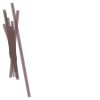

In [57]:
df2.multipolygon[0] #should definitely have 0 combo area, which it does

In [59]:
df2[df2.combo_area != 0].head()

,combo_area,elements_used,multipolygon
10747,0.040828,[],"(POLYGON ((221.3919022 -461.842414, 220.233896..."
10768,0.103986,[],"(POLYGON ((221.3919022 -461.842414, 220.233896..."
10789,0.103986,[],"(POLYGON ((221.3919022 -461.842414, 220.233896..."
11223,0.00645599,[],"(POLYGON ((221.3919022 -461.842414, 220.233896..."
14325,0.040828,[],"(POLYGON ((221.0729768 -461.0059403, 221.05012..."


In [62]:
#df2.combo_area.max()

In [60]:
# x = 14+91+364+1001+2002+3003+3432+3003+2002+1001+364+91+14+1
# print(x)#we expect this many combinations, and we get it! (= len(df2))
# #make this pretty

In [66]:
bucket2 = []
for ele in df2.index:
    #print(ele)
    polylist = df2.elements_used[ele]
    bucket = []
    for poly in polylist:
        x = df1.Obsid_Used[df1['polygon_shape'] == poly].values[0]
        bucket.append(x)
    bucket2.append(bucket)
df2['obsids_used'] = np.array(bucket2)
#use olddata and Testregion_inter, combine so that we get a list of
#the obsids used which we add to our Testregion_inter dataframe

In [27]:
#THIS IS THE REAL ONE! Save!
# bucket2 = []
# for ele in Testregion_inter.index:
#     #print(ele)
#     polylist = Testregion_inter.elements_used[ele]
#     bucket = []
#     for poly in polylist:
#         x = df1.obsid[df1['obs_poly'] == poly].values[0]
#         bucket.append(x)
#     bucket = tuple(bucket)
#     bucket2.append(bucket)
# Testregion_inter['obsids_used'] = np.array(bucket2)


In [67]:
df2.head() #check what we get, looks right!
#print(Testregion_inter.obsids_used[0])

,combo_area,elements_used,multipolygon,obsids_used
0,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_..."
1,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_..."
2,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_..."
3,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_..."
4,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_..."


In [68]:
obsdf = df2 #rename this monstrosity

In [69]:
obsdf.head()

,combo_area,elements_used,multipolygon,obsids_used
0,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_..."
1,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_..."
2,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_..."
3,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_..."
4,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_..."


In [71]:
len(obsdf)

32767

In [72]:
#this gives us the number of hirise images used in each combo
#num hirise is also num elements used, num obsids used
bucket = []
for i in range(len(obsdf.elements_used)): #change to range(len(obsdf.elements_used)) after we check
    #print(len(obsdf.elements_used[i])) #check it's what we want.
    obsdf.at[i, 'number_hirise'] = int(len(obsdf.elements_used[i]))
    #even calling it int(len) still gives float on df, but whatever.

In [73]:
obsdf.head()

,combo_area,elements_used,multipolygon,obsids_used,number_hirise
0,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_...",15.0
1,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_...",14.0
2,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_...",14.0
3,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_...",14.0
4,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_...",14.0


In [74]:
#make a test cell, create cell with similar values (100's, 150's for areas)
#figure out if the areas are correct, see if they're square km or what
#do so in testing polygons

In [75]:
#add L_s values as a list, just as we added obsids used as a list
#gives L_s values for each obsid
bucket2 = []
for obslist in obsdf.obsids_used:
    bucket = []
    for obs in obslist:
        x = olddata.Ls[olddata['obsid'] == obs].values[0]
        bucket.append(x)
    bucket = tuple(bucket)
    bucket2.append(bucket)
obsdf['Ls_used'] = np.array(bucket2)
obsdf['region_name'] = testregion

In [77]:
obsdf.head() 

,combo_area,elements_used,multipolygon,obsids_used,number_hirise,Ls_used,region_name
0,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_...",15.0,"(223.31400000000002, 247.27, 187.4779999999999...",Inca_City
1,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_...",14.0,"(223.31400000000002, 247.27, 187.4779999999999...",Inca_City
2,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_...",14.0,"(223.31400000000002, 247.27, 187.4779999999999...",Inca_City
3,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_...",14.0,"(223.31400000000002, 247.27, 187.4779999999999...",Inca_City
4,0,"[POLYGON ((221.3919022 -461.842414, 220.233896...","(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_...",14.0,"(223.31400000000002, 247.27, 187.4779999999999...",Inca_City


In [78]:
obsdf = obsdf.drop(['elements_used'], axis = 1) #drop elements_used, don't need

In [80]:
obsdf.head()
#End what I've gone over, below was for chaning to geodataframe

,combo_area,multipolygon,obsids_used,number_hirise,Ls_used,region_name
0,0,"(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_...",15.0,"(223.31400000000002, 247.27, 187.4779999999999...",Inca_City
1,0,"(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_...",14.0,"(223.31400000000002, 247.27, 187.4779999999999...",Inca_City
2,0,"(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_...",14.0,"(223.31400000000002, 247.27, 187.4779999999999...",Inca_City
3,0,"(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_...",14.0,"(223.31400000000002, 247.27, 187.4779999999999...",Inca_City
4,0,"(POLYGON ((221.3919022 -461.842414, 220.233896...","[ESP_012256_0985, ESP_012744_0985, ESP_011491_...",14.0,"(223.31400000000002, 247.27, 187.4779999999999...",Inca_City


In [39]:
obsdf = gp.GeoDataFrame(obsdf) #turn obsdf into a geodataframe

In [40]:
obsdf = obsdf.set_geometry('multipolygon') #assign the geometry column

In [41]:
obsdf.head() #make sure it looks right

,combo_area,multipolygon,obsids_used,number_hirise,Ls_used,region_name
0,0.008637,"(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",14.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield
1,0.073851,"(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield
2,0.008637,"(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield
3,0.008637,"(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield
4,0.008637,"(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield


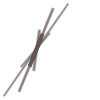

In [51]:
obsdf.multipolygon[0]

In [42]:
obsdf.to_csv('Macclesfield_duplicate_combodf.csv', index=False)
#turn this df into a csv, don't need index

In [43]:
combodf = pd.read_csv("Macclesfield_duplicate_combodf.csv")
#read in the exact same csv we created, this is obsdf read back in

In [44]:
combodf.head(2) #check our just read in file

,combo_area,multipolygon,obsids_used,number_hirise,Ls_used,region_name
0,0.008637,MULTIPOLYGON (((-67.69881540000002 255.7925763...,"['ESP_012079_0945', 'ESP_011407_0945', 'ESP_01...",14.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield
1,0.073851,MULTIPOLYGON (((-67.69881540000002 255.7925763...,"['ESP_012079_0945', 'ESP_011407_0945', 'ESP_01...",13.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield


In [45]:
obsdf.head(2) #check our original file.  Doesn't seem to match, obsdf has the proper multipolygon, this does not

,combo_area,multipolygon,obsids_used,number_hirise,Ls_used,region_name
0,0.008637,"(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",14.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield
1,0.073851,"(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield


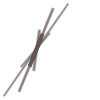

In [46]:
obsdf.multipolygon[0]

In [47]:
combodf.multipolygon[0] #oh no

'MULTIPOLYGON (((-67.69881540000002 255.7925763, -68.0397766 255.9241635, -68.2102417 255.9901059, -68.3806735 256.0561472, -66.51658209999999 260.8401089, -65.92657060000001 262.3506059, -65.7792438 262.727603, -65.4351928 263.6075048, -65.18990550000001 264.2344785, -64.9442308 264.8613011, -64.6979937 265.4875738, -64.40197689999999 266.2389609, -63.3174531 268.9907508, -63.07056650000001 269.6157661, -62.38826820000001 269.3496037, -67.5507085 256.169611, -67.6000533 256.0438146, -67.69881540000002 255.7925763)), ((-79.4964947 242.6512937, -71.77739459999999 253.8635486, -71.46847209999999 254.3115077, -70.84964120000002 255.2074994, -70.5397844 255.6551738, -70.22919159999999 256.1023187, -69.9174458 256.5497336, -56.8173104 275.3080391, -56.50581800000001 275.753868, -56.1930716 276.1998598, -55.87910890000001 276.6460092, -55.25149620000001 277.5366029, -54.9371813 277.9817438, -54.62269420000001 278.4268853, -53.6770012 279.7634786, -53.04730479999999 280.6534371, -51.4716348 2

In [48]:
#check with jmars results, what years does this catalog use?
#split up the catalog by year, so we have 2 per region, one for mars year 29, one for mars year 30
#test with this one first, make sure it looks like the hirise image.

#clean up notebook, make the tests with jmars, make sure that the obsids don't actually equal anymore which means checking combinatorics, and make it so we can split this by mars year.  Will have to figure out how to do this.